In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV # for hyperparameter tuning
import optuna as optuna # for hyperparameter tuning
from sklearn.preprocessing import StandardScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from imblearn.over_sampling import SMOTE
import shape # for model interpretability

In [2]:
df = pd.read_csv("../data/preprocessed_data.csv") 
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,...,Ratio_Balance_Age,Ratio_Salary_Age,Engagement_Score,Ratio_Products_Age,Relative_Salary,Ratio_CreditScore_Age,Zero_Balance_HasCrCard,Low_Balance_Active,Active_HasCrCard,Log_Salary
0,683.0,Germany,Male,49.0,7.0,123837.86,2.0,1.0,1.0,138700.75,...,2527.303265,2830.627551,4.0,0.040816,1.161679,13.938776,False,False,1.0,11.840081
1,608.0,France,Female,30.0,10.0,0.00,2.0,1.0,1.0,146723.72,...,0.000000,4890.790667,4.0,0.066667,1.248591,20.266667,True,True,1.0,11.896313
2,539.0,France,Female,32.0,8.0,0.00,1.0,1.0,1.0,94873.60,...,0.000000,2964.800000,3.0,0.031250,0.807356,16.843750,True,True,1.0,11.460311
3,530.0,Spain,Female,39.0,8.0,0.00,2.0,0.0,0.0,177896.93,...,0.000000,4561.459744,2.0,0.051282,1.511382,13.589744,False,False,0.0,12.088965
4,613.0,France,Female,45.0,10.0,0.00,2.0,1.0,1.0,116748.14,...,0.000000,2594.403111,4.0,0.044444,0.993504,13.622222,True,True,1.0,11.667783


In [3]:
# Define features and target variable
X = df.drop("Exited", axis=1)
y = df["Exited"]

In [4]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
# Identify numerical and categorical columns
num_var = X.select_dtypes(include=["float64", "int64"]).columns
cat_var = X.select_dtypes(include=["object","category"]).columns

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_var),           
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_var)
    ]
)

In [7]:
y.value_counts()

Exited
0    12010
1     2990
Name: count, dtype: int64

In [8]:
# Evaluation function
def evaluate_model(y_test, y_pred, y_prob):
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1-score:", f1_score(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.show()

=== Logistic Regression ===
Accuracy: 0.8116666666666666
Precision: 0.5174234424498416
Recall: 0.8193979933110368
F1-score: 0.6343042071197411
AUC: 0.8911971350518938

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      2402
           1       0.52      0.82      0.63       598

    accuracy                           0.81      3000
   macro avg       0.73      0.81      0.75      3000
weighted avg       0.86      0.81      0.83      3000



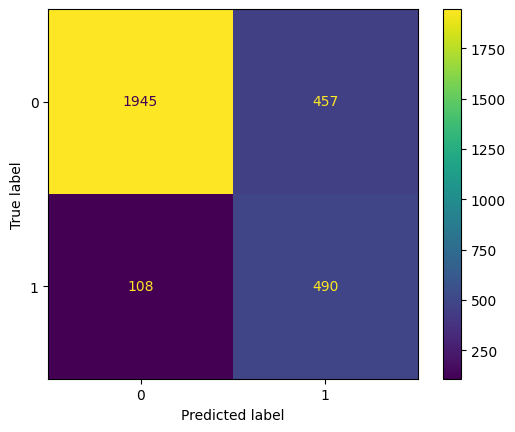


=== Random Forest ===
Accuracy: 0.8833333333333333
Precision: 0.6845238095238095
Recall: 0.7692307692307693
F1-score: 0.7244094488188977
AUC: 0.9297825947719155

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2402
           1       0.68      0.77      0.72       598

    accuracy                           0.88      3000
   macro avg       0.81      0.84      0.83      3000
weighted avg       0.89      0.88      0.89      3000



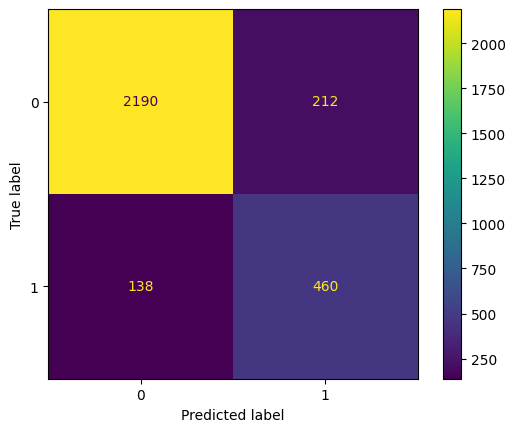


=== XGBoost ===
Accuracy: 0.882
Precision: 0.6728045325779037
Recall: 0.794314381270903
F1-score: 0.7285276073619632
AUC: 0.9313044592159823

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      2402
           1       0.67      0.79      0.73       598

    accuracy                           0.88      3000
   macro avg       0.81      0.85      0.83      3000
weighted avg       0.89      0.88      0.89      3000



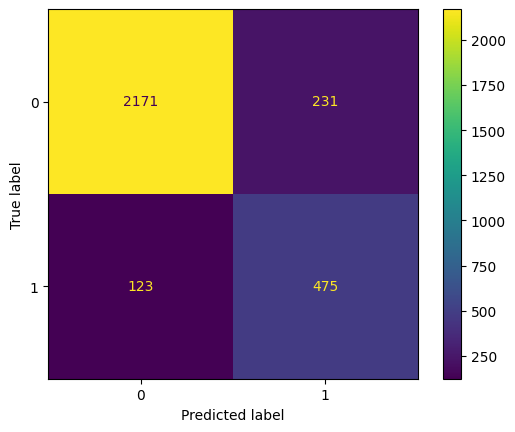

In [9]:
# ===========================
# Logistic Regression Model
# ===========================
log_reg = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
evaluate_model(y_test, y_pred_lr, y_prob_lr)


# ===========================
# Random Forest Model
# ===========================
rf = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=10,
        class_weight='balanced',
        random_state=42
    ))
])

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
evaluate_model(y_test, y_pred_rf, y_prob_rf)


# ===========================
# XGBoost Model
# ===========================
xgb = Pipeline(steps=[
    ('preprocess', preprocessor),
    ('model', XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=3,  # gérer le déséquilibre
        eval_metric='logloss',
        random_state=42
    ))
])

xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

print("\n=== XGBoost ===")
evaluate_model(y_test, y_pred_xgb, y_prob_xgb)


In [16]:

from sklearn.model_selection import StratifiedKFold, cross_validate

# Définir un K-Fold stratifié (important pour les classes déséquilibrées)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Fonction utilitaire pour afficher les résultats de la validation croisée
def cross_val_results(model, X, y):
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc'
    }
    
    results = cross_validate(
        model, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        return_train_score=False
    )
    
    print("----- Cross Validation Scores -----")
    for metric in scoring.keys():
        print(f"{metric}: {results[f'test_{metric}'].mean():.4f} ± {results[f'test_{metric}'].std():.4f}")
    print("\n")  # pour espacer les résultats

# ===========================
# Validation croisée sur les modèles
# ===========================
print("=== Cross Validation: Logistic Regression ===")
cross_val_results(log_reg, X_train, y_train)

print("=== Cross Validation: Random Forest ===")
cross_val_results(rf, X_train, y_train)

print("=== Cross Validation: XGBoost ===")
cross_val_results(xgb, X_train, y_train)


=== Cross Validation: Logistic Regression ===
----- Cross Validation Scores -----
accuracy: 0.8129 ± 0.0089
precision: 0.5200 ± 0.0142
recall: 0.8052 ± 0.0131
f1: 0.6319 ± 0.0142
roc_auc: 0.8851 ± 0.0090


=== Cross Validation: Random Forest ===
----- Cross Validation Scores -----
accuracy: 0.8129 ± 0.0089
precision: 0.5200 ± 0.0142
recall: 0.8052 ± 0.0131
f1: 0.6319 ± 0.0142
roc_auc: 0.8851 ± 0.0090


=== Cross Validation: Random Forest ===
----- Cross Validation Scores -----
accuracy: 0.8893 ± 0.0050
precision: 0.7020 ± 0.0124
recall: 0.7730 ± 0.0131
f1: 0.7358 ± 0.0118
roc_auc: 0.9318 ± 0.0056


=== Cross Validation: XGBoost ===
----- Cross Validation Scores -----
accuracy: 0.8893 ± 0.0050
precision: 0.7020 ± 0.0124
recall: 0.7730 ± 0.0131
f1: 0.7358 ± 0.0118
roc_auc: 0.9318 ± 0.0056


=== Cross Validation: XGBoost ===
----- Cross Validation Scores -----
accuracy: 0.8858 ± 0.0030
precision: 0.6829 ± 0.0084
recall: 0.7972 ± 0.0075
f1: 0.7356 ± 0.0064
roc_auc: nan ± nan


----- Cross 

Total features after preprocessing: 22


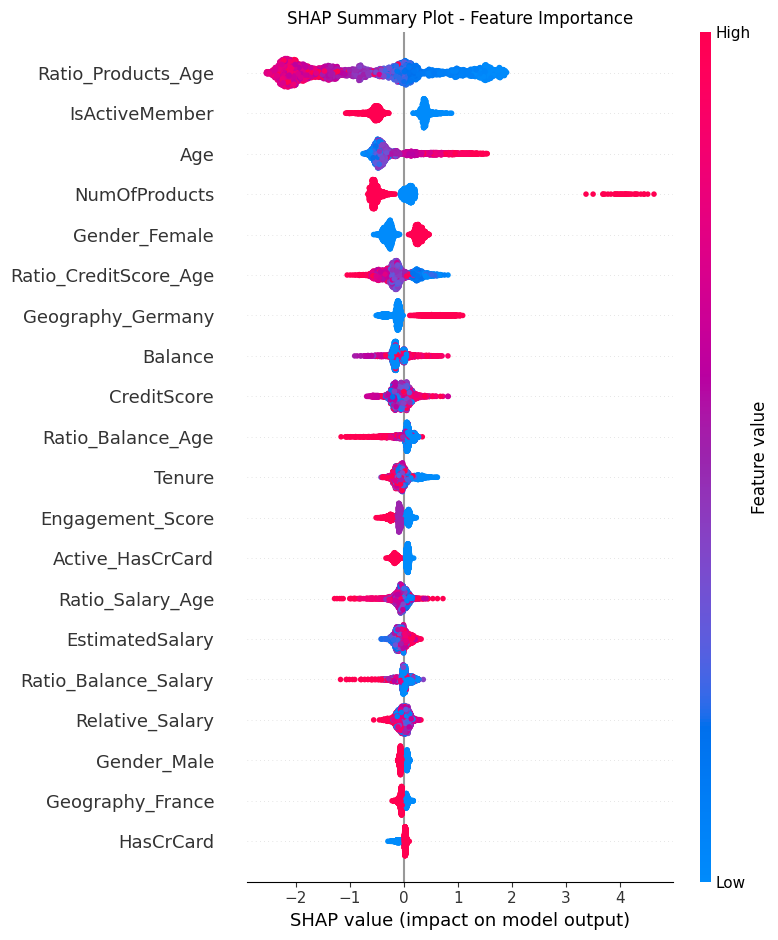

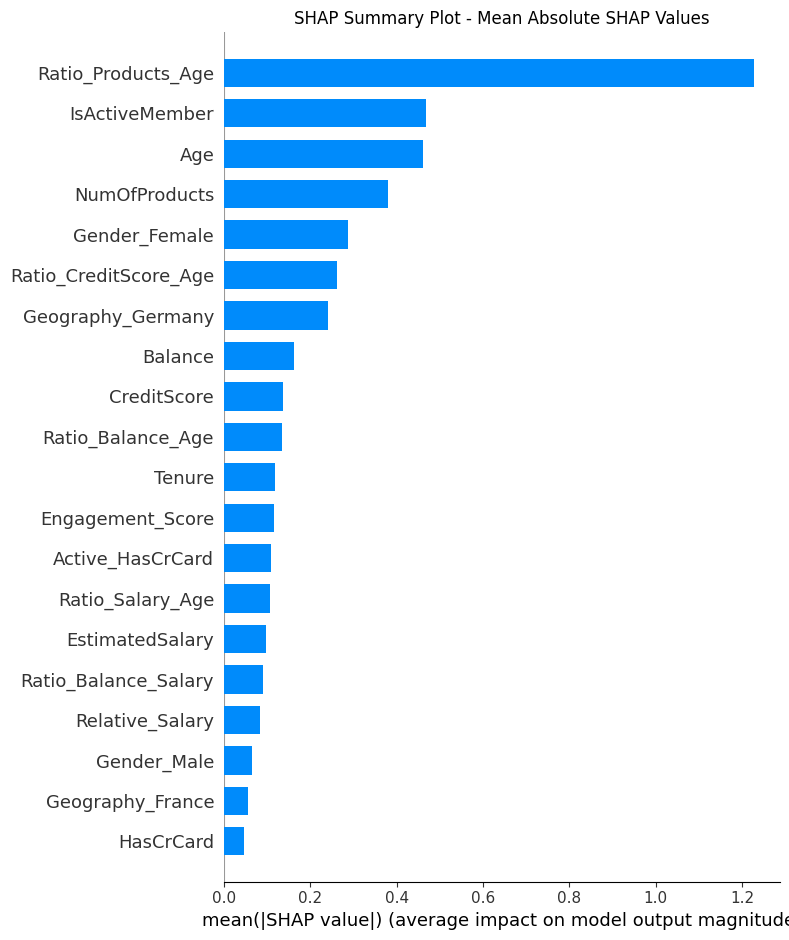


Top 10 most important features:
  Ratio_Products_Age: 1.2264
  IsActiveMember: 0.4679
  Age: 0.4618
  NumOfProducts: 0.3798
  Gender_Female: 0.2871
  Ratio_CreditScore_Age: 0.2613
  Geography_Germany: 0.2410
  Balance: 0.1625
  CreditScore: 0.1358
  Ratio_Balance_Age: 0.1350


In [12]:
# SHAP Feature Importance for XGBoost with Pipeline
import shap

# Extract the preprocessor and model from the pipeline
preprocessor_xgb = xgb.named_steps['preprocess']
xgb_model = xgb.named_steps['model']

# Preprocess the test data
X_test_preprocessed = preprocessor_xgb.transform(X_test)

# Create SHAP explainer with the raw XGBoost model (not the pipeline)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_preprocessed)

# Get feature names after preprocessing
feature_names = (
    list(preprocessor_xgb.named_transformers_['num'].get_feature_names_out(num_var)) +
    list(preprocessor_xgb.named_transformers_['cat'].get_feature_names_out(cat_var))
)

print(f"Total features after preprocessing: {len(feature_names)}")

# SHAP summary plots
plt.figure(figsize=(12, 6))
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, show=False)
plt.title("SHAP Summary Plot - Feature Importance")
plt.tight_layout()
plt.show()

# Bar plot (mean absolute SHAP values)
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test_preprocessed, feature_names=feature_names, plot_type="bar", show=False)
plt.title("SHAP Summary Plot - Mean Absolute SHAP Values")
plt.tight_layout()
plt.show()

# Top 10 most important features
top_features_idx = np.argsort(np.abs(shap_values).mean(axis=0))[-10:]
print("\nTop 10 most important features:")
for idx in reversed(top_features_idx):
    print(f"  {feature_names[idx]}: {np.abs(shap_values[:, idx]).mean():.4f}")
